# <font size=7> 9장 평균 회귀 전략</font>
# Pairs Trading

### 코드 9-5 F, GM, AAPL 주가 정규화와 그래프 출력

[*********************100%***********************]  3 of 3 completed


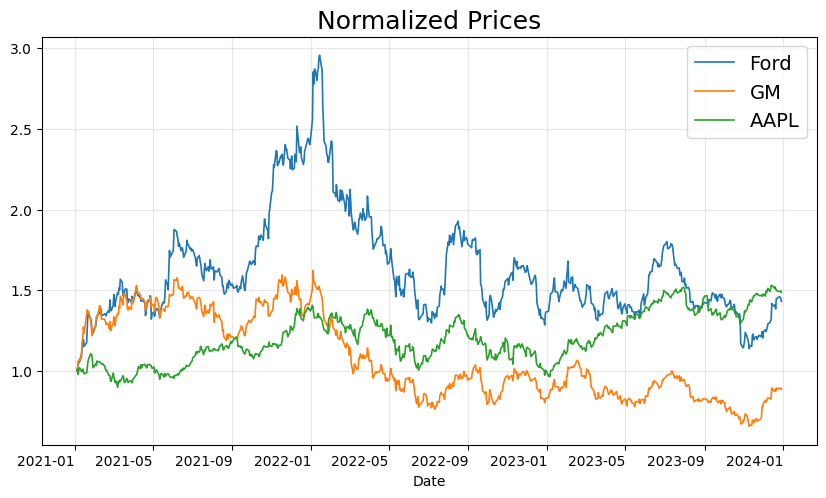

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

tickers = ['F', 'GM', 'AAPL']
start = '2021-01-01'
end = '2024-01-01'
df = yf.download(tickers, start, end, multi_level_index=False, auto_adjust=False)

# 종가 분리
ford = df['Close']['F']
gm = df['Close']['GM']
aapl = df['Close']['AAPL']

# 주가 정규화
ford_n = ford/ford.iloc[0]
gm_n = gm/gm.iloc[0]
aapl_n = aapl/aapl.iloc[0]

# 시각화
fig, ax = plt.subplots(figsize=(10,6))
ford_n.plot(ax=ax, label='Ford', linewidth=1.2)
gm_n.plot(ax=ax, label='GM', linewidth=1.2)
aapl_n.plot(ax=ax, label='AAPL', linewidth=1.2)
ax.set_title('Normalized Prices', fontsize=18)
ax.grid(alpha=0.3)
ax.legend(fontsize=14)
plt.xticks(rotation=0)
plt.show()

### 코드 9-6 F, GM, AAPL 주가 산점도 출력

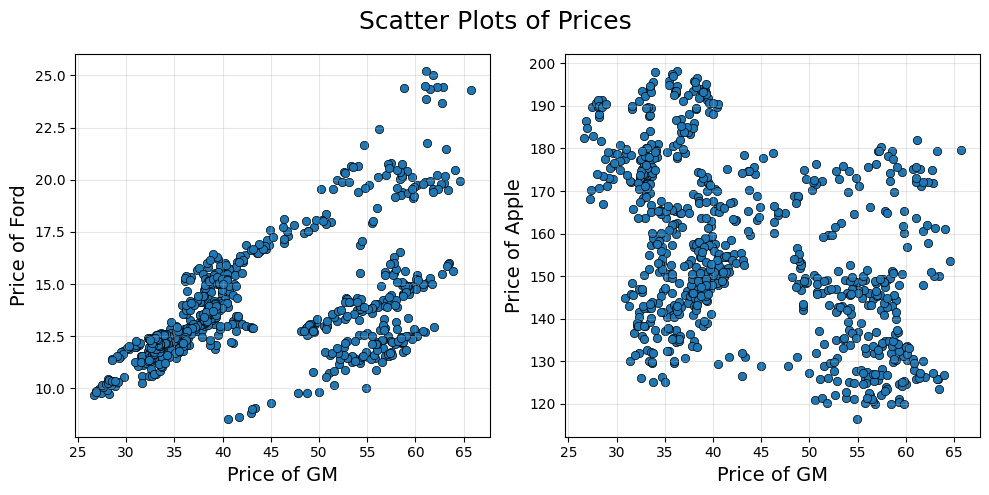

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(gm, ford, edgecolor='k', linewidth=0.5)
ax[0].set_xlabel('Price of GM', fontsize=14)
ax[0].set_ylabel('Price of Ford', fontsize=14)
ax[0].grid(alpha=0.3)

ax[1].scatter(gm, aapl, edgecolor='k', linewidth=0.5)
ax[1].set_xlabel('Price of GM', fontsize=14)
ax[1].set_ylabel('Price of Apple', fontsize=14)
ax[1].grid(alpha=0.3)

fig.suptitle('Scatter Plots of Prices', fontsize=18)
plt.tight_layout()
plt.show()

### 코드 9-7 F, GM, AAPL 수익률 산점도 출력

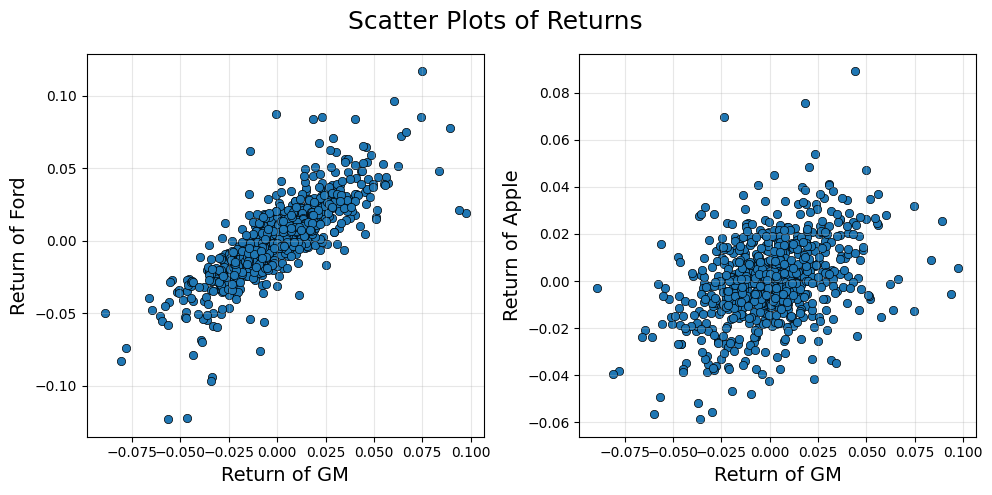

In [7]:
# 수익률 계산
ford_ret = df['Close']['F'].pct_change()
gm_ret = df['Close']['GM'].pct_change()
aapl_ret = df['Close']['AAPL'].pct_change()

# 산점도 시각화
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(gm_ret, ford_ret, edgecolor='k', linewidth=0.5)
ax[0].set_xlabel('Return of GM', fontsize=14)
ax[0].set_ylabel('Return of Ford', fontsize=14)
ax[0].grid(alpha=0.3)

ax[1].scatter(gm_ret, aapl_ret, edgecolor='k', linewidth=0.5)
ax[1].set_xlabel('Return of GM', fontsize=14)
ax[1].set_ylabel('Return of Apple', fontsize=14)
ax[1].grid(alpha=0.3)

fig.suptitle('Scatter Plots of Returns', fontsize=18)
plt.tight_layout()
# plt.savefig('pt_03.png', dpi=300)
plt.show()

### 코드 9-8 상관계수 계산하기

In [9]:
# 상관계수 구하기
cor1 = ford_ret.corr(gm_ret)
cor2 = aapl_ret.corr(gm_ret)
print(f'Correlation Coefficient Between F and GM: {cor1}')
print(f'Correlation Coefficient Between AAPL and GM: {cor2}')

Correlation Coefficient Between F and GM: 0.8125005756050772
Correlation Coefficient Between AAPL and GM: 0.38935949957237775


In [10]:
# 상관계수 표 구하기
df['Close'].pct_change().corr()

Ticker,AAPL,F,GM
Ticker,,,
AAPL,1.000000,0.379446,0.389359
F,0.379446,1.000000,0.812501
GM,0.389359,0.812501,1.000000


In [11]:
df['Close'].pct_change().corr().values

array([[1.        , 0.37944621, 0.3893595 ],
       [0.37944621, 1.        , 0.81250058],
       [0.3893595 , 0.81250058, 1.        ]])

### 코드 9-9 상관관계 매트릭스 히트맵 출력하기

[*********************100%***********************]  12 of 12 completed


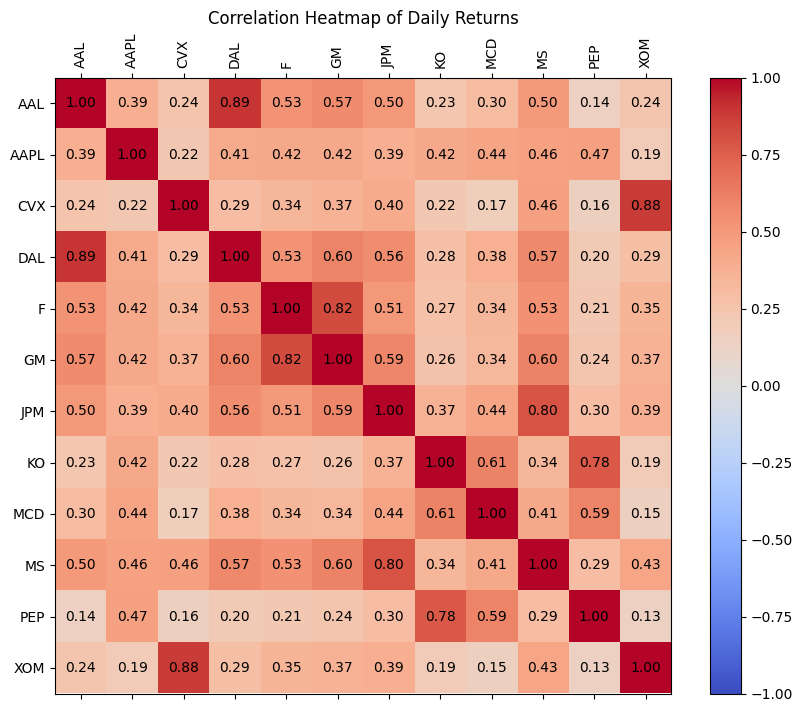

In [13]:
tickers = ['F', 'GM', 'AAPL', 'AAL', 'DAL', 'XOM', 'CVX', 'JPM', 'MS', 'KO','PEP', 'MCD']
# df = yf.download(tickers, start='2019-01-01', end='2024-01-01')
df = yf.download(tickers, start='2021-01-01', end='2023-01-01', multi_level_index=False, auto_adjust=False)

returns = df['Close'].pct_change().dropna()
tickers = list(returns.columns)
corr_matrix = returns.corr()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ax.set_xticks(np.arange(len(tickers)))
ax.set_yticks(np.arange(len(tickers)))
ax.set_xticklabels(tickers, rotation=90)
ax.set_yticklabels(tickers)

for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.title('Correlation Heatmap of Daily Returns')
plt.show()

### 코드 9-10 상관관계 높은 페어 찾는 함수

In [15]:
def correlated_pair_finder(matrix, val):
    n = matrix.shape[1]
    cols = matrix.columns
    corr_pairs = []
    for i in range(n):
        for j in range(i+1,n):
            corr = matrix.iloc[i,j]
            if corr >= val:
                # corr_pairs.append((cols[i],cols[j]))
                corr_pairs.append((cols[i],cols[j], round(corr,3)))
    return corr_pairs

corr_pairs = correlated_pair_finder(corr_matrix, 0.59)
print(corr_pairs)

[('AAL', 'DAL', np.float64(0.894)), ('CVX', 'XOM', np.float64(0.879)), ('DAL', 'GM', np.float64(0.598)), ('F', 'GM', np.float64(0.82)), ('GM', 'JPM', np.float64(0.592)), ('GM', 'MS', np.float64(0.605)), ('JPM', 'MS', np.float64(0.797)), ('KO', 'MCD', np.float64(0.606)), ('KO', 'PEP', np.float64(0.778)), ('MCD', 'PEP', np.float64(0.594))]


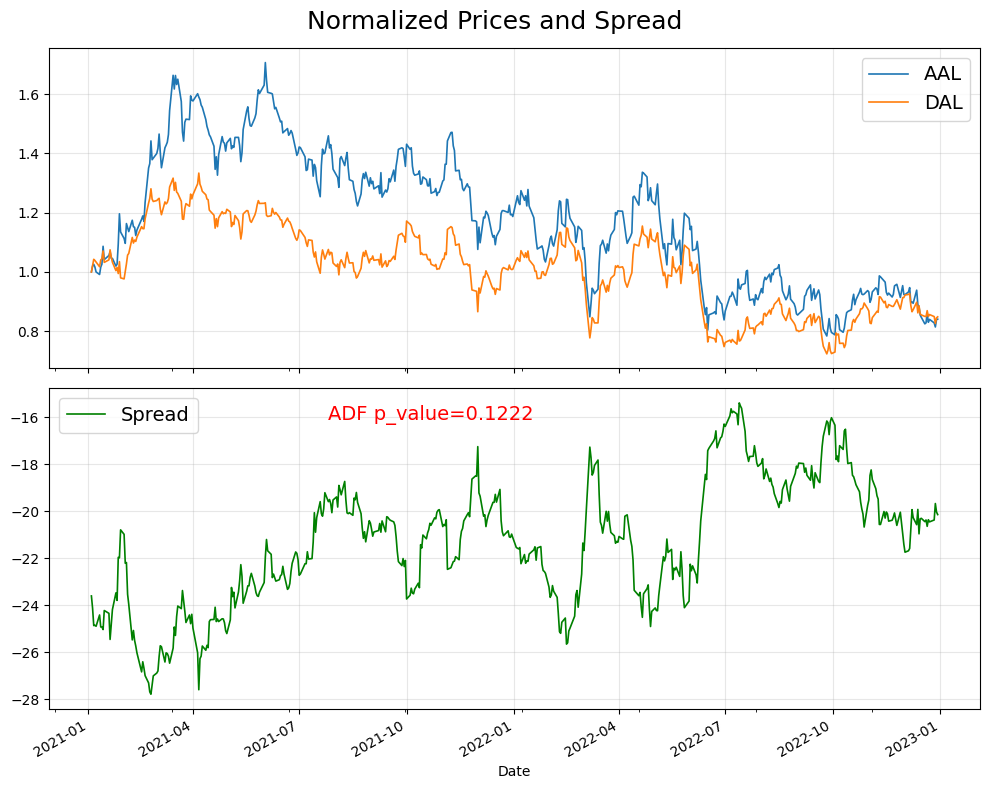

In [16]:
from statsmodels.tsa.stattools import adfuller

ticker_A = 'AAL'; ticker_B = 'DAL'
# ticker_A = 'CVX'; ticker_B = 'XOM'

stock_A = df['Close'][ticker_A]
stock_B = df['Close'][ticker_B]
spread = stock_A - stock_B

p_value = adfuller(spread)[1]

stock_A_n = stock_A/stock_A.iloc[0]
stock_B_n = stock_B/stock_B.iloc[0]

fig, ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
stock_A_n.plot(ax=ax[0], label=ticker_A, linewidth=1.2)
stock_B_n.plot(ax=ax[0], label=ticker_B, linewidth=1.2)
ax[0].grid(alpha=0.3)
ax[0].legend(fontsize=14)

spread.plot(ax=ax[1], label='Spread', color='green', linewidth=1.2)
ax[1].text(x=0.3, y=0.9, s=f'ADF p_value={p_value:.4f}', transform=ax[1].transAxes, fontsize=14, color='red')
ax[1].grid(alpha=0.3)
ax[1].legend(fontsize=14)

plt.suptitle('Normalized Prices and Spread', fontsize=18)
plt.tight_layout()
plt.show()

### 코드 9-11 상관관계 높지만 공적분 관계 아닌 예

Correlation Coefficient: 0.9823634584807182
Cointegration test p_value: 0.7603076236639248
X and Y are not likely cointegrated.


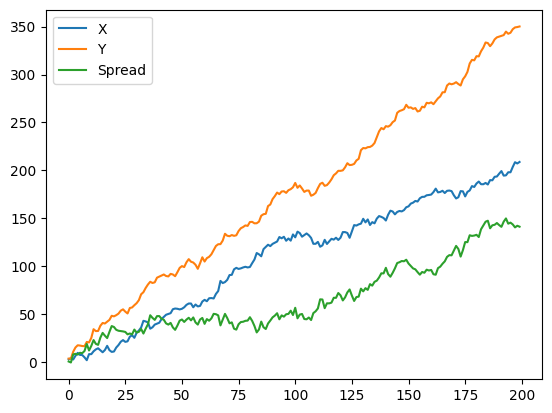

In [18]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
np.random.seed(23)

# 합성 데이터 생성
x_ret = np.random.normal(1,3,200)
y_ret = np.random.normal(2,3,200)
X = pd.Series(x_ret.cumsum(), name='X')
Y = pd.Series(y_ret.cumsum(), name='Y')

# 상관계수 계산
cor = X.corr(Y)
print(f'Correlation Coefficient: {cor}')

# 공적분 테스트
score, p_value, _ = coint(X,Y)
print(f'Cointegration test p_value: {p_value}')

if p_value < 0.05:
    print('X and Y are likely cointegrated.')
else:
    print('X and Y are not likely cointegrated.')

# 스프레드
S = Y - X
S.name = 'Spread'

# 시각화
df = pd.concat([X, Y, S],axis=1)
fig, ax = plt.subplots()
df.plot(ax=ax)
# plt.savefig('pt_06.png', dpi=300)
plt.show()

### 코드 9-12 공적분 관계에 있지만 상관관계 낮은 예

Correlation Coefficient: 0.004914449085040132
Cointegration test p_value: 1.1301469499714991e-07
X and Y are likely cointegrated.


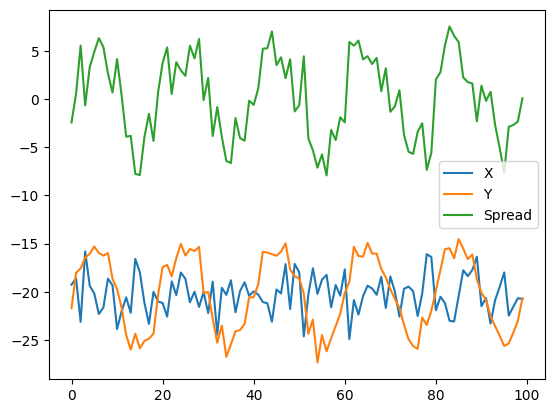

In [20]:
# 합성 데이터 생성
X = pd.Series(np.random.normal(0,2,100) - 20, name='X')
sine = 5*np.sin(np.pi/10*np.arange(0,100)) - 20
noise = np.random.normal(0,1,100)
Y = pd.Series(sine+noise, name='Y')

# 상관계수 계산
cor = X.corr(Y)
print(f'Correlation Coefficient: {cor}')

# 공적분 테스트
score, p_value, _ = coint(X,Y)
print(f'Cointegration test p_value: {p_value}')

if p_value < 0.05:
    print('X and Y are likely cointegrated.')
else:
    print('X and Y are not likely cointegrated.')

# 스프레드
S = Y - X
S.name = 'Spread'

# 시각화
df = pd.concat([X, Y, S],axis=1)
fig, ax = plt.subplots()
df.plot(ax=ax)
# plt.savefig('pt_07.png', dpi=300)
plt.show()

### 코드 9-13 공적분 관계 필터 함수

In [22]:
tickers = ['F', 'GM', 'AAPL', 'AAL', 'DAL', 'XOM', 'CVX', 'JPM', 'MS', 'KO','PEP', 'MCD']
# df = yf.download(tickers, start='2019-01-01', end='2024-01-01')
df = yf.download(tickers, start='2021-01-01', end='2023-01-01', multi_level_index = False, auto_adjust=False)

[*********************100%***********************]  12 of 12 completed


In [23]:
def cointegration_filter(corr_pairs, threshold=0.05):
    coint_pairs = []
    for ticker1, ticker2, _r in corr_pairs:
        price1 = df['Close'][ticker1]
        price2 = df['Close'][ticker2]
        score, pvalue, _ = coint(price1,price2)
        if pvalue < threshold:
            coint_pairs.append((ticker1, ticker2, round(pvalue,4)))
    if len(coint_pairs) > 0:
        print(f'{len(coint_pairs)} cointegrated pair(s) found.')
    else:
        print('No cointegrated pair(s) found.')
    return coint_pairs

coint_pairs = cointegration_filter(corr_pairs, 0.1)
coint_pairs

2 cointegrated pair(s) found.


[('DAL', 'GM', np.float64(0.0743)), ('MCD', 'PEP', np.float64(0.004))]

### 코드 9-14 PEP, MCD의 분석 및 스프레드 구하기

[*********************100%***********************]  2 of 2 completed


Correlation between Returns: 0.5943
Correlation between Prices: 0.9168
Cointegration test p_value: 0.020489340351459853
X and Y are cointegrated at 5% significance level.
Hedge Ratio: 1.1032576381917005
ADF test p_value: 0.0007289620187143441
Spread is stationary at 5% significance level.


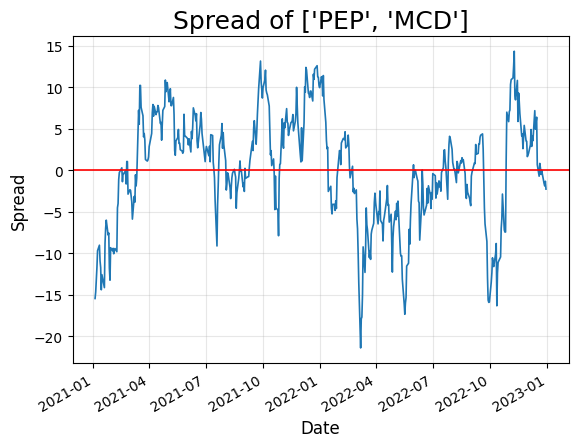

In [25]:
# 데이터 다운로드
ticker1 = 'PEP'; ticker2 = 'MCD'
tickers = [ticker1, ticker2]
df = yf.download(tickers, '2021-01-01', '2023-01-01',multi_level_index=False, auto_adjust=False)
Y = df['Close'][ticker2]
X = df['Close'][ticker1]

# 상관관계 테스트
ret1 = X.pct_change().fillna(0)
ret2 = Y.pct_change().fillna(0)
cor1 = ret1.corr(ret2) # 수익률 상관관계
cor2 = X.corr(Y) # 주가 상관관계
print(f'Correlation between Returns: {cor1:.4f}')
print(f'Correlation between Prices: {cor2:.4f}')

# 공적분 테스트
score, p_value, _ = coint(X,Y)
print(f'Cointegration test p_value: {p_value}')

if p_value < 0.05:
    print('X and Y are cointegrated at 5% significance level.')
elif p_value < 0.1:
    print('X and Y are cointegrated at 10% significance level.')    
else:
    print('X and Y are not likely cointegratedat.')

# 선형회귀에 의한 헤지 비율 계산
X_with_const = sm.add_constant(X)
model = sm.OLS(Y, X_with_const).fit()
alpha = model.params['const']
beta = model.params[ticker1]
print(f'Hedge Ratio: {beta}')

# 스프레드
spread = Y - (beta*X + alpha)

# 스프레드 정상성 테스트
adf_p_value = adfuller(spread)[1]
print(f'ADF test p_value: {adf_p_value}')

if adf_p_value < 0.05:
    print('Spread is stationary at 5% significance level.')
elif adf_p_value < 0.1:
    print('Spread is stationary at 10% significance level.')    
else:
    print('Spread is not likely stationary.')

# 스프레드 시각화
fig, ax = plt.subplots()
spread.plot(ax=ax, linewidth=1.2)
ax.axhline(y=spread.mean(), color='r', linewidth=1.2)
ax.grid(alpha=0.3)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Spread', fontsize=12)
ax.set_title(f'Spread of {tickers}', fontsize=18)
plt.show()

### 코드 9-15 PEP, MCD의 스프레드 Z-Score로 변환

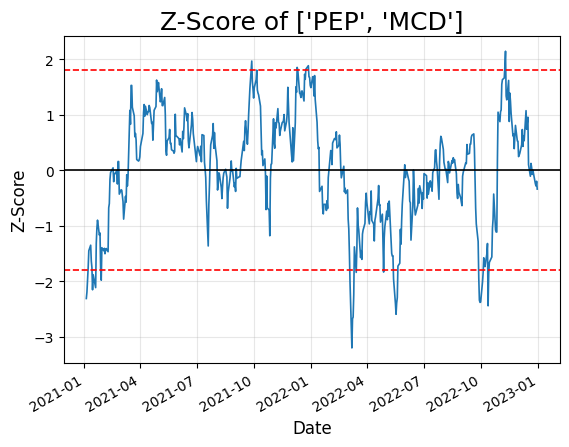

In [27]:
#  Z-Score 계산
spread_mean = spread.mean()
spread_std = spread.std()
z_score = (spread - spread_mean)/spread_std

# Z-Score 시각화
fig, ax = plt.subplots()
z_score.plot(ax=ax, linewidth=1.2)
ax.axhline(y=0, color='k', linewidth=1.2)
ax.axhline(y=1.8, color='red', linewidth=1.2, linestyle='--')
ax.axhline(y=-1.8, color='red', linewidth=1.2, linestyle='--')
ax.grid(alpha=0.3)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Z-Score', fontsize=12)
ax.set_title(f'Z-Score of {tickers}', fontsize=18)
plt.show()

### 코드 9-16 PEP, MCD에 대한 페어 트레이딩 백테스트1

total_cum_return:21.47%


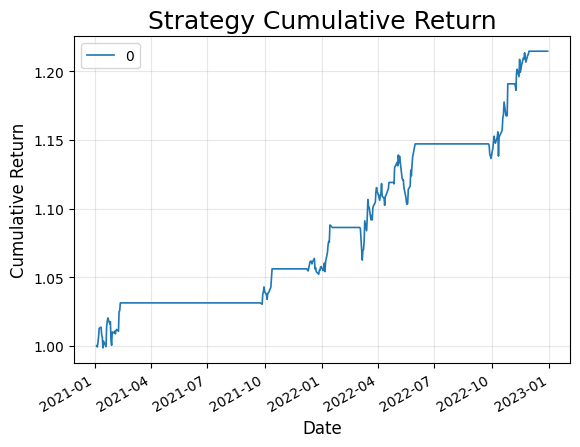

In [29]:
# 파라미터 값
entry_threshold = 1.8
exit_threshold = 0.3

# 포지션 계산
stock1_pos = pd.Series(data=0, index=z_score.index) # PEP
stock2_pos = pd.Series(data=0, index=z_score.index) # MCD

for i in range(1,len(z_score)):
    if z_score.iloc[i]<-entry_threshold and stock2_pos.iloc[i-1]==0:
        stock2_pos.iloc[i] = 1 # long stock2
        stock1_pos.iloc[i] = -1 # short stock1
    elif z_score.iloc[i]>entry_threshold and stock2_pos.iloc[i-1]==0:
        stock2_pos.iloc[i] = -1 # short stock2
        stock1_pos.iloc[i] = 1 # long stock1   
    elif abs(z_score.iloc[i]) < exit_threshold:
        stock1_pos.iloc[i] = 0
        stock2_pos.iloc[i] = 0
    else:
        stock1_pos.iloc[i] = stock1_pos.iloc[i-1]
        stock2_pos.iloc[i] = stock2_pos.iloc[i-1]

# 백테스트
fee_rate = 0.001
cash_init = 10000
cash = cash_init
asset = np.zeros(len(X))
asset[0] = cash

zscore = z_score.values
price_A = X.values   
price_B = Y.values   
pos = 0

for i in range(1, len(X)):
    if pos == 0 and cash > 0:
        if stock1_pos.iloc[i] == 1: # 매수: long A, short B
            pos = 1           
            entry_price_A = price_A[i]
            entry_price_B = price_B[i]
            num_A = \
            int( cash/( (entry_price_A+beta*entry_price_B)*(1+fee_rate) ) )
            num_B = int(beta*num_A)
            cash -= entry_price_A*num_A*(1+fee_rate) # A 매수 대금 + 수수료 지불
            cash -= entry_price_B*num_B*fee_rate # 빌린 B 매도 수수료 지불

        elif stock1_pos.iloc[i] == -1: # 매도: short A, long B
            pos = -1
            entry_price_A = price_A[i]
            entry_price_B = price_B[i]
            num_A = \
            int( cash/( (entry_price_A+beta*entry_price_B)*(1+fee_rate) ) )
            num_B = int(beta*num_A)
            cash -= entry_price_B*num_B*(1+fee_rate) # B 매수 대금 + 수수료 지불
            cash -= entry_price_A*num_A*fee_rate # 빌린 A 매도 수수료 지불          

    elif pos == 1:          
        if stock1_pos.iloc[i] == 0: # 매수 청산
            pos = 0  
            cash += price_A[i]*num_A*(1-fee_rate)
            cash += (entry_price_B - price_B[i])*num_B - price_B[i]*num_B*fee_rate               

    elif pos == -1:        
        if stock1_pos.iloc[i] == 0: # 매도 청산
            pos = 0
            cash += (entry_price_A - price_A[i])*num_A - price_A[i]*num_A*fee_rate    
            cash += price_B[i]*num_B*(1-fee_rate)               
          
    # asset 갱신
    if pos == 0:
        asset[i] = cash
    elif pos == 1:
        asset[i] = cash + price_A[i]*num_A + (entry_price_B - price_B[i])*num_B
    elif pos == -1:
        asset[i] = cash + price_B[i]*num_B + (entry_price_A - price_A[i])*num_A    

# 누적 수익률 계산
cumulative_returns = asset/cash_init   
print(f'total_cum_return:{100*(cumulative_returns[-1]-1):.2f}%')

# 누적 수익률 시각화
cumulative_returns = pd.DataFrame(cumulative_returns, index=X.index)
fig, ax = plt.subplots()
cumulative_returns.plot(ax=ax, linewidth=1.2)
ax.set_title('Strategy Cumulative Return', fontsize=18)
ax.grid(alpha=0.3)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
plt.show()

### 코드 9-17 PEP, MCD에 대한 Rolling Regression

[*********************100%***********************]  2 of 2 completed


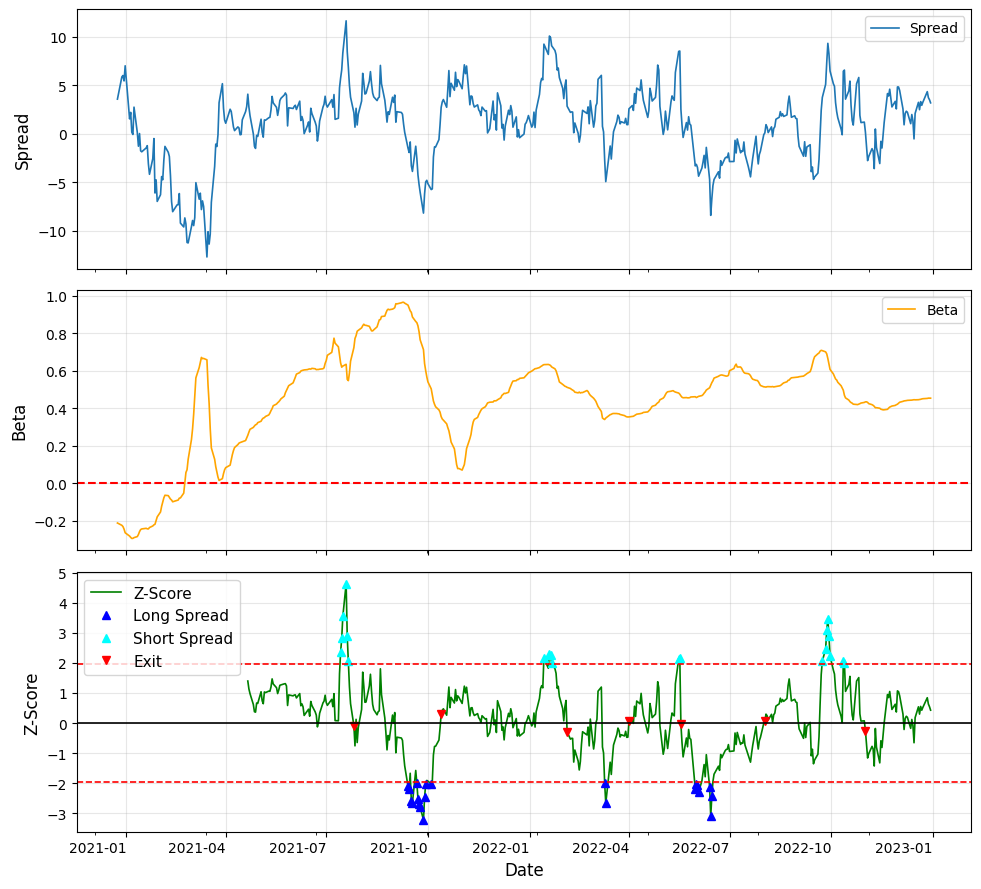

In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# 데이터 다운로드
ticker_A = 'PEP'; ticker_B = 'MCD'
df = yf.download([ticker_A,ticker_B],'2020-09-01','2023-01-01', multi_level_index=False, auto_adjust=False)
prices_A = df['Close'][ticker_A]
prices_B = df['Close'][ticker_B]

# 파라미터 세팅
window_size = 80
entry_threshold = 1.96
exit_threshold = 0.0

# Rolling Regression
betas = []
spreads = []
z_scores = []
signals = []
pos = 0

for t in range(window_size, len(prices_A)):
    # Rolling window data
    Y = prices_A.iloc[t - window_size:t]
    X = prices_B.iloc[t - window_size:t]
    
    # Add constant for intercept
    X_with_const = add_constant(X)
    
    # OLS Regression
    model = OLS(Y, X_with_const).fit()
    alpha_t = model.params['const']
    beta_t = model.params[X.name]
    betas.append(beta_t)
    
    # Current prices
    Y_t = prices_A.iloc[t]
    X_t = prices_B.iloc[t]
    
    # Calculate spread 스프레드 계산
    epsilon_t = Y_t - alpha_t - beta_t * X_t
    spreads.append(epsilon_t)
    
    # rolling mean, rolling std, Z-Score 계산
    if len(spreads) >= window_size:
        spread_windowed = spreads[-window_size:]
        mu_t = np.mean(spread_windowed)
        sigma_t = np.std(spread_windowed, ddof=1)
        z_t = (epsilon_t - mu_t) / sigma_t
        z_scores.append(z_t)

        # 거래 신호 생성
        if z_t > entry_threshold:
            signals.append(-1)  # Short the spread(Short A, Long B)
            pos = -1
        elif z_t < -entry_threshold:
            signals.append(1)   # Long the spread(Long A, Short B)
            pos = 1
        elif z_t < exit_threshold and pos == -1:
            signals.append(0)   # Exit positions(Cover A, Sell B)
            pos = 0
        elif z_t > -exit_threshold and pos == 1:
            signals.append(0)   # Exit positions(Sell A, Cover B)
            pos = 0
        else:
            signals.append(np.nan)  # Hold position
    else:
        z_scores.append(np.nan)
        signals.append(np.nan)

# 판다스 시리즈 만들기
result_index = prices_A.index[window_size:]
hedge_ratios = pd.Series(betas, index=result_index)
spreads = pd.Series(spreads, index=result_index)
z_scores = pd.Series(z_scores, index=result_index)
signals = pd.Series(signals, index=result_index)

Long_Entry = pd.Series(np.where(signals==1, z_scores, np.nan), \
                       index=result_index)
Exits = pd.Series(np.where(signals==0, z_scores, np.nan), \
                  index=result_index)
Short_Entry = pd.Series(np.where(signals==-1, z_scores, np.nan), \
                        index=result_index)

# Visualization 시각화

# Plot the spread over time
fig, ax =plt.subplots(3,1, figsize=(10, 9), sharex=True)
spreads.plot(ax=ax[0], label='Spread', linewidth=1.2)
ax[0].set_ylabel('Spread', fontsize=12)
ax[0].legend()
ax[0].grid(alpha=0.3)

# Plot beta over time
hedge_ratios.plot(ax=ax[1], color='orange', label='Beta', linewidth=1.2)
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_ylabel('Beta', fontsize=12)
ax[1].legend()
ax[1].grid(alpha=0.3)

# Plot the z-score over time
z_scores.plot(ax=ax[2], color='green', label='Z-Score', linewidth=1.2)
Long_Entry.plot(ax=ax[2], marker='^', linestyle='None', color='b', \
                markersize=6, label='Long Spread')
Short_Entry.plot(ax=ax[2], marker='^', linestyle='None', color='cyan', \
                 markersize=6, label='Short Spread')
Exits.plot(ax=ax[2], marker='v', linestyle='None', color='r', \
           markersize=6, label='Exit')
ax[2].axhline(entry_threshold, color='red', linestyle='--', linewidth=1.2)
ax[2].axhline(-entry_threshold, color='red', linestyle='--', linewidth=1.2)
ax[2].axhline(0, color='black', linestyle='-', linewidth=1.2)
ax[2].set_xlabel('Date', fontsize=12)
ax[2].set_ylabel('Z-Score', fontsize=12)
ax[2].legend(loc='upper left', fontsize=11)
ax[2].grid(alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 코드 9-18 PEP, MCD에 대한 페어 트레이딩 백테스트2

In [33]:
# 백테스트 파라미터
fee_rate = 0.001
stop_loss = 0.15

# 백테스트 위한 데이터프레임 만들기
data = pd.DataFrame(index=result_index)
data['Price_A'] = prices_A[result_index]
data['Price_B'] = prices_B[result_index]
data['Hedge_Ratio'] = hedge_ratios
data['Z-Score'] = z_scores

# 매수 신호: long A, Short B
positions1 = pd.Series(np.where(data['Z-Score']<-entry_threshold, 1, 0),\
                      index=data.index)
signals1 = positions1.diff().fillna(0).values

# 매수 청산 신호: Sell A, Cover B
positions2 = pd.Series(np.where(data['Z-Score']> -exit_threshold, 1, 0),\
                      index=data.index)
signals2 = positions2.diff().fillna(0).values

# 매도 신호: Short A, Long B
positions3 = pd.Series(np.where(data['Z-Score']>entry_threshold, 1, 0),\
                      index=data.index)
signals3 = positions3.diff().fillna(0).values

# 매도 청산 신호: Cover A, Sell B
positions4 = pd.Series(np.where(data['Z-Score']<exit_threshold, 1, 0),\
                      index=data.index)
signals4 = positions4.diff().fillna(0).values

# 백테스트 루프
cash_init = 10000
cash = cash_init
asset = np.zeros(len(data))
asset[0] = cash

pos_vec = np.zeros(len(data))  
zscore = z_scores.values
price_A = data.iloc[:,0].values   
price_B = data.iloc[:,1].values   
beta = hedge_ratios.values
pos = 0

for i in range(1, len(data)):
    if pos == 0 and cash > 0:
        if signals1[i] == 1: # 매수: long A, short B, z_score가 올라갈 것을 기대
            pos = 1
            pos_vec[i] = 1
            entry_asset = cash
            stop_loss_asset = entry_asset*(1-stop_loss)
            entry_price_A = price_A[i]
            entry_price_B = price_B[i]
            num_A = \
            int( cash/( (entry_price_A+beta[i]*entry_price_B)*(1+fee_rate) ) )
            num_B = int(beta[i]*num_A)
            cash -= entry_price_A*num_A*(1+fee_rate) # A 매수 대금 + 수수료 지불
            cash -= entry_price_B*num_B*fee_rate # 빌린 B 매도 수수료 지불

        elif signals3[i] == 1: # 매도: short A, long B, z_score가 내려갈 것을 기대
            pos = -1
            pos_vec[i] = -1
            entry_asset = cash
            stop_loss_asset = entry_asset*(1-stop_loss)    
            entry_price_A = price_A[i]
            entry_price_B = price_B[i]
            num_A = \
            int( cash/( (entry_price_A+beta[i]*entry_price_B)*(1+fee_rate) ) )
            num_B = int(beta[i]*num_A)
            cash -= entry_price_B*num_B*(1+fee_rate) # B 매수 대금 + 수수료 지불
            cash -= entry_price_A*num_A*fee_rate # 빌린 A 매도 수수료 지불              

    elif pos == 1:          
        current_asset = cash + price_A[i]*num_A + \
        (entry_price_B - price_B[i])*num_B
        if signals2[i] == 1: # 매수 청산
            pos = 0  
            cash += price_A[i]*num_A*(1-fee_rate)
            cash += (entry_price_B - price_B[i])*num_B - \
            price_B[i]*num_B*fee_rate                     

        elif current_asset < stop_loss_asset: # 매수 손절
            pos = 0  
            cash += price_A[i]*num_A*(1-fee_rate)
            cash += (entry_price_B - price_B[i])*num_B - \
            price_B[i]*num_B*fee_rate   
        else:  
            pos_vec[i] = 1           

    elif pos == -1:        
        current_asset = cash + price_B[i]*num_B + \
        (entry_price_A - price_A[i])*num_A
        if signals4[i] == 1: # 매도 청산
            pos = 0
            cash += (entry_price_A - price_A[i])*num_A - \
            price_A[i]*num_A*fee_rate    
            cash += price_B[i]*num_B*(1-fee_rate)                    

        elif current_asset < stop_loss_asset: # 매도 손절
            pos = 0
            cash += (entry_price_A - price_A[i])*num_A - \
            price_A[i]*num_A*fee_rate    
            cash += price_B[i]*num_B*(1-fee_rate)               
            
        else:  
            pos_vec[i] = -1           
          
    # asset 갱신
    if pos == 0:
        asset[i] = cash
    elif pos == 1:
        asset[i] = cash + price_A[i]*num_A + \
        (entry_price_B - price_B[i])*num_B
    elif pos == -1:
        asset[i] = cash + price_B[i]*num_B + \
        (entry_price_A - price_A[i])*num_A

# 포지션과 시그널 확정
data['Position'] = pos_vec
data['Signal'] = data['Position'].diff().fillna(0)

# 거래 시점 기록
cond1 = (data['Position']==1)&(data['Signal']==1)
data['Long_Entry_A'] = np.where(cond1, data['Price_A'], np.nan)   
data['Short_Entry_B'] = np.where(cond1, data['Price_B'], np.nan)   
data['Long_Entry'] = np.where(cond1, data['Z-Score'], np.nan)   

cond2 = (data['Position']==0)&(data['Signal']==-1)
data['Long_Exit_A'] = np.where(cond2, data['Price_A'], np.nan) 
data['Short_Exit_B'] = np.where(cond2, data['Price_B'], np.nan)   
data['Long_Exit'] = np.where(cond2, data['Z-Score'], np.nan) 

cond3 = (data['Position']==-1)&(data['Signal']==-1)
data['Short_Entry_A'] = np.where(cond3, data['Price_A'], np.nan)  
data['Long_Entry_B'] = np.where(cond3, data['Price_B'], np.nan)  
data['Short_Entry'] = np.where(cond3, data['Z-Score'], np.nan)  

cond4 = (data['Position']==0)&(data['Signal']==1)
data['Short_Exit_A'] = np.where(cond4, data['Price_A'], np.nan)     
data['Long_Exit_B'] = np.where(cond4, data['Price_B'], np.nan)  
data['Short_Exit'] = np.where(cond4, data['Z-Score'], np.nan)       

# 누적 수익률 계산
data['Cumulative_Return'] = asset/cash_init
final_cum_return = data['Cumulative_Return'].iloc[-1] - 1
print(f'Final cumulative return of the strategy: '
          f'{100*final_cum_return:.2f}%')

# 샤프 지수 Sharpe Ratio
risk_free_rate = 0.003
strategy_daily_return = data['Cumulative_Return'].pct_change().fillna(0)
mean_return = strategy_daily_return.mean()*252
std_return = strategy_daily_return.std()*np.sqrt(252)
sharpe_ratio = (mean_return - risk_free_rate) / std_return
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

# 최대 낙폭 Maximum Drawdown
data['Cumulative_Max'] = data['Cumulative_Return'].cummax()
data['Drawdown'] = data['Cumulative_Return'] / data['Cumulative_Max'] - 1
max_drawdown = data['Drawdown'].min() 
print(f'Strategy MDD: {100*max_drawdown:.2f}%')

Final cumulative return of the strategy: 8.90%
Sharpe Ratio: 0.93
Strategy MDD: -2.56%


### 코드 9-19 PEP, MCD에 대한 페어 트레이딩 백테스트2의 결과 시각화

[*********************100%***********************]  1 of 1 completed


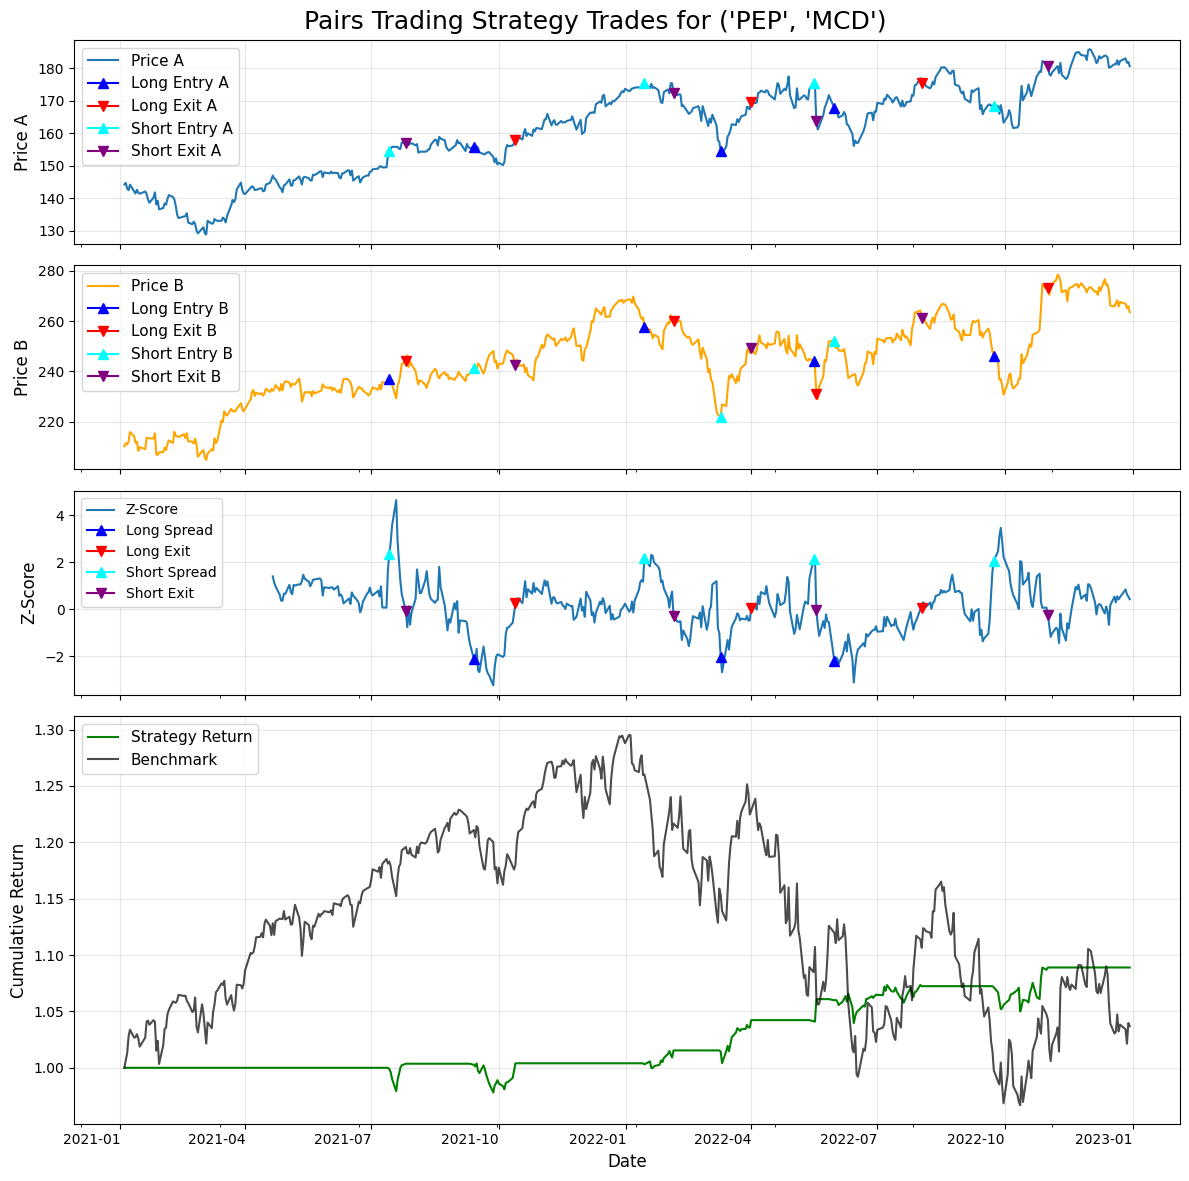

In [35]:
spy = yf.download('SPY', start='2021-01-01', end='2023-01-01', multi_level_index=False, auto_adjust=False)
benchmark = spy['Close']/spy['Close'].iloc[0]

fig, ax = plt.subplots(4,1,figsize=(12, 12),sharex=True,height_ratios=(1,1,1,2))

plt.suptitle(f'Pairs Trading Strategy Trades for {ticker_A, ticker_B}', fontsize=18)

data['Price_A'].loc['2021-01-01':].plot(ax=ax[0], label='Price A')
data['Long_Entry_A'].loc['2021-01-01':].plot(ax=ax[0], label='Long Entry A', marker='^', color='b', markersize=7)
data['Long_Exit_A'].loc['2021-01-01':].plot(ax=ax[0], label='Long Exit A', marker='v', color='r', markersize=7)
data['Short_Entry_A'].loc['2021-01-01':].plot(ax=ax[0], label='Short Entry A', marker='^', color='cyan', markersize=7)
data['Short_Exit_A'].loc['2021-01-01':].plot(ax=ax[0], label='Short Exit A', marker='v', color='purple', markersize=7)

ax[0].set_ylabel('Price A', fontsize=12)
ax[0].legend(loc='upper left', fontsize=11)
ax[0].grid(alpha=0.3)

data['Price_B'].loc['2021-01-01':].plot(ax=ax[1], color='orange', label='Price B')
data['Long_Entry_B'].loc['2021-01-01':].plot(ax=ax[1], label='Long Entry B', marker='^', color='b', markersize=7)
data['Long_Exit_B'].loc['2021-01-01':].plot(ax=ax[1], label='Long Exit B', marker='v', color='r', markersize=7)
data['Short_Entry_B'].loc['2021-01-01':].plot(ax=ax[1], label='Short Entry B', marker='^', color='cyan', markersize=7)
data['Short_Exit_B'].loc['2021-01-01':].plot(ax=ax[1], label='Short Exit B', marker='v', color='purple', markersize=7)

ax[1].set_ylabel('Price B', fontsize=12)
ax[1].legend(loc='upper left', fontsize=11)
ax[1].grid(alpha=0.3)

data['Z-Score'].loc['2021-01-01':].plot(ax=ax[2], label='Z-Score')
data['Long_Entry'].loc['2021-01-01':].plot(ax=ax[2], label='Long Spread', marker='^', color='b', markersize=7)
data['Long_Exit'].loc['2021-01-01':].plot(ax=ax[2], label='Long Exit', marker='v', color='r', markersize=7)
data['Short_Entry'].loc['2021-01-01':].plot(ax=ax[2], label='Short Spread', marker='^', color='cyan', markersize=7)
data['Short_Exit'].loc['2021-01-01':].plot(ax=ax[2], label='Short Exit', marker='v', color='purple', markersize=7)

ax[2].set_ylabel('Z-Score', fontsize=12)
ax[2].legend(loc='upper left', fontsize=10)
ax[2].grid(alpha=0.3)

data['Cumulative_Return'].loc['2021-01-01':].plot(ax=ax[3], color='g', label='Strategy Return')
benchmark.plot(ax=ax[3], color='k', label='Benchmark', alpha=0.7)

ax[3].set_xlabel('Date', fontsize=12)
ax[3].set_ylabel('Cumulative Return', fontsize=12)
ax[3].legend(loc='upper left', fontsize=11)
ax[3].grid(alpha=0.3)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()